# Camera Calibration with Gradio UI

In [1]:
%pip install gradio numpy opencv-python matplotlib pytransform3d

Note: you may need to restart the kernel to use updated packages.


In [2]:
from functools import partial
import time
import gradio
import os
import json
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt
import pytransform3d.camera as pc
import pytransform3d.transformations as pt
import io
from pathlib import Path

def cv2_imshow(img):
    cv.imshow("img", img)
    time.sleep(1)
    cv.destroyAllWindows()

CONTENT_DIR = Path(".")

try:
    import google.collab.patches as patches
    cv2_imshow = patches.cv2_imshow
    CONTENT_DIR = Path("/content")
except:
    pass

/Users/yavanni/Projects/CSE5283/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Camera Calibration

In [3]:
image_dir = CONTENT_DIR / "images"
images = list(image_dir.glob("*.jpeg")) + list(image_dir.glob("*.jpg"))


class Calibration:
    @staticmethod
    def run():
        # termination criteria
        criteria = (
            cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER,
            30,
            0.001,
        )  # 30: max_iter , 0.001 : accuracy

        # prepare object points, like (0,0,0), (1,0,0), ..., (6,5,0)
        objp = np.zeros((9 * 6, 3), np.float32)  #
        objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(
            -1, 2
        )  # reshaped to [42,2] only take X and Y


        calibration_data = {}

        CHECKERBOARD_SIZE = (9, 6)

        for fname in images:
            # Arrays to store object points and image points from all the images.
            objpoints: list[cv.typing.MatLike] = []  # 3d point in real world space [X,Y,Z]
            imgpoints: list[cv.typing.MatLike] = []  # 2d points in image plane. [X,Y]

            print(fname)
            img = cv.imread(str(fname))

            if img is None:
                print("Invalid image")
                continue

            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

            # Find the chess board corners
            ret, corners = cv.findChessboardCorners(gray, CHECKERBOARD_SIZE, None)

            # If found, add object points, image points (after refining them)
            if ret == True:
                objpoints.append(objp)

                corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
                imgpoints.append(corners2)

                # Draw and display the corners
                cv.drawChessboardCorners(img, CHECKERBOARD_SIZE, corners2, ret)
                # cv.imshow("img", img)
                # cv.waitKey(500)

                cv.imwrite(str(CONTENT_DIR / "output" / (fname.name + "_corners.png")), img)

                # Calibration Part
                ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)  # type: ignore

                img = cv.imread(str(fname))

                if img is None:
                    continue

                h, w = img.shape[:2]
                # newcameramtx, roi = cv.getOptimalNewCameraMatrix(
                #     mtx, dist, (w, h), 0, (w, h)
                # )

                # dst = cv.undistort(img, mtx, dist, None, newcameramtx)
                
                # # crop the image
                # x, y, w, h = roi
                # dst = dst[y:y+h, x:x+w]

                # cv.imwrite(str(CONTENT_DIR / "output" / (fname.name + "_undistort.png")), dst)

                # Save results into calibration.json
                calibration_data[str(fname)] = (
                    {
                        "K": mtx.tolist(),  # Intrinsic matrix
                        "D": dist.tolist(),  # Distortion coefficients
                        "R": [
                            cv.Rodrigues(r)[0].tolist() for r in rvecs
                        ],  # Convert rvec to rotation matrix
                        "t": [t.tolist() for t in tvecs],  # Translation vectors
                        "width": w,
                        "height": h,
                    }
                )

                mean_error = 0
                for i in range(len(objpoints)):
                    imgpoints2, _ = cv.projectPoints(
                        objpoints[i], rvecs[i], tvecs[i], mtx, dist
                    )
                    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2) / len(imgpoints2)
                    mean_error += error

                print("total error: {}".format(mean_error / len(objpoints)))

        with open("calibration.json", "w") as f:
            json.dump(calibration_data, f, indent=2)

        return calibration_data

In [4]:
Calibration.run()

images/IMG_6713.jpg
total error: 0.03169090484093545
images/IMG_6707.jpg
total error: 0.025195708164087352
images/IMG_6706.jpg
total error: 0.02438504256457315
images/IMG_6712.jpg
total error: 0.02733515829283164
images/IMG_6704.jpg
total error: 0.02591630111925812
images/IMG_6710.jpg
total error: 0.027700642623343395
images/IMG_6711.jpg
total error: 0.02993629320094708
images/IMG_6705.jpg
total error: 0.026549450994940303
images/IMG_6729.jpg
total error: 0.02678475785334184
images/IMG_6715.jpg
total error: 0.02559616109420546
images/IMG_6714.jpg
total error: 0.03521515722741326
images/IMG_6728.jpg
total error: 0.02228891050019366
images/IMG_6716.jpg
total error: 0.511181482880999
images/IMG_6703.jpg
total error: 0.02569154678730216
images/IMG_6717.jpg
total error: 0.029422015166252154
images/IMG_6732.jpg
total error: 0.02473621818537208
images/IMG_6726.jpg
total error: 0.024397112243425285
images/IMG_6727.jpg
total error: 0.025014310560552123
images/IMG_6733.jpg
total error: 0.0267920

{'images/IMG_6713.jpg': {'K': [[4560.783763372529, 0.0, 2045.3690367197783],
   [0.0, 4422.609165630453, 2525.681527817438],
   [0.0, 0.0, 1.0]],
  'D': [[0.13654462106327991,
    0.41577964081884666,
    -0.011944484620031106,
    -0.006002088858602447,
    -2.1135653043136933]],
  'R': [[[0.07812704627342244, -0.9545193131457881, -0.2877308559614064],
    [0.9461137533196964, -0.019991606260816624, 0.3232168025620412],
    [-0.31426888236016554, -0.2974780941696473, 0.9015219648290812]]],
  't': [[[4.202976146839139], [-1.998278599109771], [23.67773616515165]]],
  'width': 4284,
  'height': 5712},
 'images/IMG_6707.jpg': {'K': [[3313.174851857412, 0.0, 2350.225979033761],
   [0.0, 3271.0445638425467, 2727.7300323696036],
   [0.0, 0.0, 1.0]],
  'D': [[0.09467335812158202,
    0.00609838570344731,
    -0.002929013052959047,
    0.0046864627871229135,
    -0.19183008054840356]],
  'R': [[[-0.03761323407384403, -0.9980072084592354, 0.05066415385566566],
    [0.9915302611949605, -0.030966

### Visualization

### Utils

In [5]:
class Utils:
    @staticmethod
    def project_points(W: np.ndarray,
                       Lambda: np.ndarray,
                       Rt: np.ndarray) -> np.ndarray:
        """ Helper function to project 3D points to 2D image plane"""

        # Convert points to homogeneous coordinates
        W_tilde = np.vstack((W, np.ones((1, W.shape[1]))))

        print(f"W_tilde = \n{W_tilde}\n")

        # Calculate perspective projection in homogeneous coordinates
        X_tilde = Lambda @ Rt @ W_tilde

        print(f"X_tilde =  \n{X_tilde}\n")

        # Apply perspective division to convert coordinates from homogeneous to Cartesian
        X_tilde /= X_tilde[2,:]
        # Convert coordinates from homogeneous to Cartesian
        X = X_tilde[0:2,:]

        return X

    @staticmethod
    def draw_coordinate_frame(image_points, img):
        x0, y0 = image_points[:,0].astype(int)
        cv.circle(img, (x0, y0), 9, (0, 0, 0), -1)

        x1, y1 = image_points[:,1].astype(int)
        img = cv.arrowedLine(img, (x0, y0), (x1, y1), (255, 0, 0), 5)

        x2, y2 = image_points[:,2].astype(int)
        img = cv.arrowedLine(img, (x0, y0), (x2, y2), (0, 255, 0), 5)

        x3, y3 = image_points[:,3].astype(int)
        img = cv.arrowedLine(img, (x0, y0), (x3, y3), (0, 0, 255), 5)

        plt.imshow(img)

    @staticmethod
    def build_Lambda(phi_x, phi_y, skew, delta_x, delta_y):
        """ Build the intrinsic camera matrix Lambda """
        Lambda = np.array([[phi_x,  skew, delta_x],
                           [    0, phi_y, delta_y],
                           [    0,     0,       1]])
        return Lambda

    @staticmethod
    def json_read(filename):
        # Parses the json file
        try:
            with open(os.path.abspath(filename)) as f:
                data = json.load(f)
            return data
        except:
            raise ValueError("Unable to read JSON {}".format(filename))

### Main

W = 
[[0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]

Projected image points = 
[[2858.46617373 2909.6852106  2499.69291474 2695.90960948]
 [2148.28329576 2503.37777396 2132.87500086 2289.1454704 ]]

W = 
[[0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]

Projected image points = 
[[2365.73490108 2350.11976651 1965.34226893 2382.19453972]
 [2158.88503066 2552.46002749 2150.11627448 2265.4371847 ]]

W = 
[[0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]

Projected image points = 
[[2341.44223979 2322.88343673 1950.81759417 2372.77632394]
 [2174.03514796 2560.22107206 2170.47388272 2293.39802785]]

W = 
[[0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]

Projected image points = 
[[2560.341689   2592.13136172 2200.7579388  2383.48488265]
 [2183.45182396 2564.4166003  2162.30293032 2282.72461694]]

W = 
[[0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]

Projected image points = 
[[2348.21010645 2316.58507927 1969.08329306 2417.7041082 ]
 [2187.14193711 2569.32401619 2182.28746133 2316.62811018]]



[<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>]

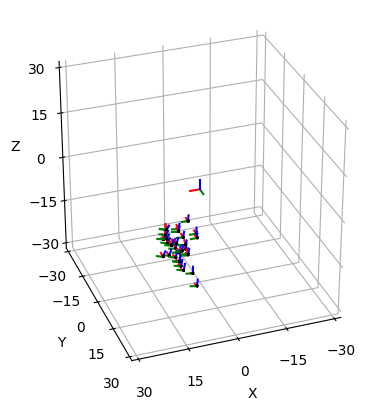

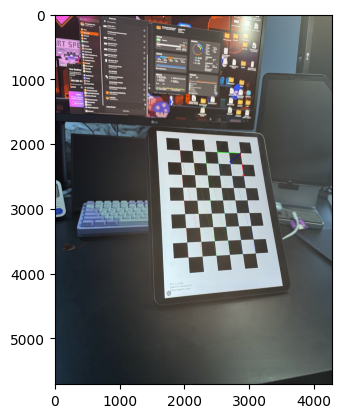

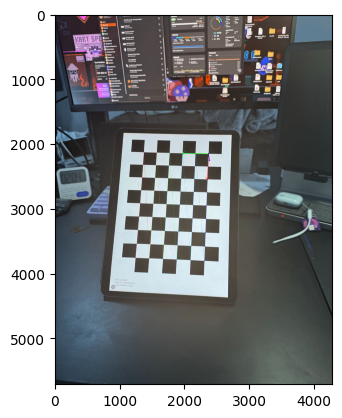

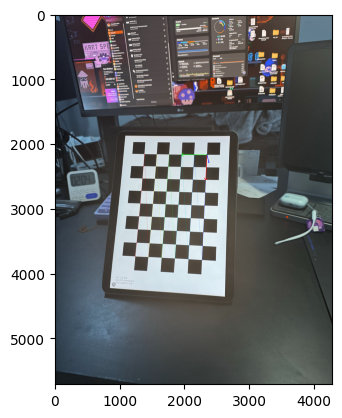

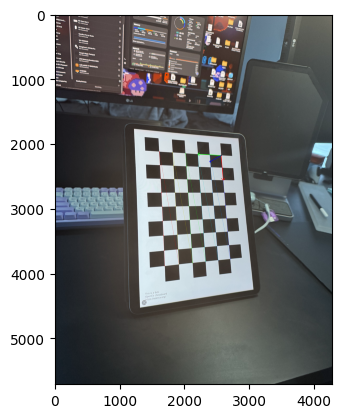

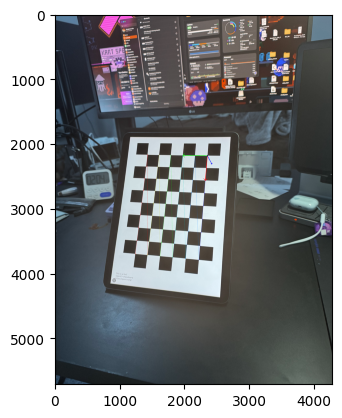

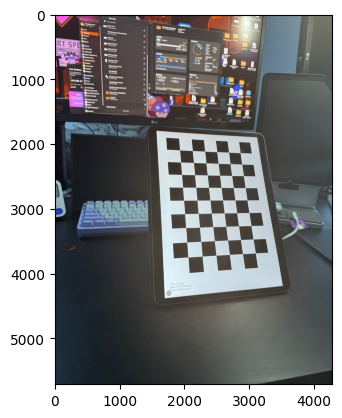

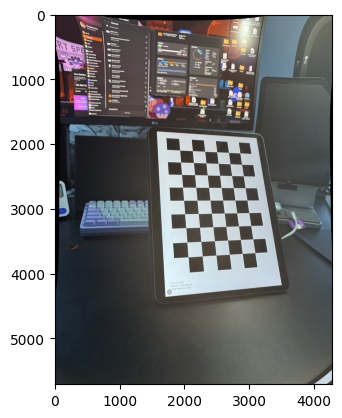

In [6]:
class Visualization:
    @staticmethod
    def calibration_matrices(view: dict) -> tuple[np.ndarray, ...]:
        # Get the calibration matrices
        Lambda = np.array(view["K"])  # Intrinsic params.
        Omega = np.array(view["R"])  # Rotation
        tau = np.array(view["t"])  # Translation
        dist = np.array(view["D"])  # Lens distortion

        Lambda = Lambda.reshape(3, 3)
        Omega = Omega.reshape(3, 3)
        tau = tau.reshape(3, 1)

        return (Lambda, Omega, tau, dist)

    @staticmethod
    def undistort(view: dict, img: cv.typing.MatLike):
        Lambda, Omega, tau, dist = Visualization.calibration_matrices(view)

        fig = plt.figure()
        plt.imshow(img)

        scale_factor = 2
        W = scale_factor * np.array(
            [[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=np.float64
        )

        rvec = cv.Rodrigues(Omega)[0]
        tvec = tau.reshape(3, 1)

        print(f"W = \n{W}\n")

        image_axes, jac = cv.projectPoints(W, rvec, tvec, Lambda, dist)
        image_axes = image_axes.squeeze().T
        print(f"Projected image points = \n{image_axes}\n")

        Utils.draw_coordinate_frame(image_axes, img)

        return fig

    @staticmethod
    def plot_camera(
        Lambda: np.ndarray, Omega: np.ndarray, tau: np.ndarray, dimensions: list[int]
    ):
        sensor_size = np.array(dimensions)
        intrinsic_matrix = Lambda

        virtual_image_distance = 0.1

        # This is the camera coordinate frame
        # Camera pose, i.e., the matrix [R t] of extrinsic parameters
        Rt = np.block([Omega.T, -Omega.T @ tau])

        # Convert Rt from 3x4 to a 4x4 transformation matrix
        Rt = np.vstack([Rt, [0, 0, 0, 1]])

        # Print camera extrinsic parameters

        cam2world = Rt
        ax = pt.plot_transform(
            A2B=cam2world,
            s=2,
            # name="Camera"
        )

        pc.plot_camera(
            ax,
            cam2world=cam2world,
            M=intrinsic_matrix,
            sensor_size=sensor_size,
            virtual_image_distance=virtual_image_distance,
        )


        return ax

    @staticmethod
    def get_calibration_data():
        with open("calibration.json", "r") as f:
            calibration_data: dict[str, dict] = json.loads(f.read())

        return calibration_data

    @staticmethod
    def plot_cameras():
        calibration_data = Visualization.get_calibration_data()

        fig = plt.figure()

        for img in images:
            view = calibration_data[str(img)]

            img = cv.imread(str(images[0]))

            if img is None:
                continue

            Lambda, Omega, tau, _ = Visualization.calibration_matrices(view)

            ax = Visualization.plot_camera(
                Lambda,
                Omega,
                tau,
                img.shape[:2]
            )

     
        cam2world = pt.transform_from_pq([0, 0, 0, 0, 0, 0, 0])
        pt.plot_transform(
            ax,
            A2B=cam2world,
            s=3,
            # name="World"
        )


        ax.view_init(30, 70)
        ax.set_xlim(-32, 32)
        ax.set_ylim(-32, 32)
        ax.set_zlim(-32, 32)
        
        return fig


    @staticmethod
    def show_world_axis():
        calibration_data = Visualization.get_calibration_data()
        
        bufs = []
        for i, (img) in enumerate(images):
            if i >= 5:
                break

            view = calibration_data[str(img)]

            img = cv.imread(str(CONTENT_DIR / "output" / (img.name + "_corners.png")))

            if img is None:
                continue

            bufs.append(Visualization.undistort(view, img))

        return bufs
    
    @staticmethod
    def distort_preview():
        normal = plt.figure()

        img = cv.imread(str(images[0]))

        if img is None:
            raise Exception("Failed to read img")
        
        plt.imshow(img)

        undistorted = plt.figure()

        calibration_data = Visualization.get_calibration_data()

        Lambda, _, _, dist = Visualization.calibration_matrices(calibration_data[str(images[0])])
        img_corrected = cv.undistort(img, Lambda, dist)
        plt.imshow(img_corrected)

        return [normal, undistorted]

    @staticmethod
    def run():
        camera = Visualization.plot_cameras()
        axises = Visualization.show_world_axis()
        distortion = Visualization.distort_preview()

        

        return [camera, *axises, *distortion]


Visualization.run()



### Gradio UI

In [9]:


class GradioUI:
  @staticmethod
  def save_images(images):
    for image in images:
      destination = image_dir / Path(image.name).name
      with open(image.name, "rb") as src, open(destination, "wb") as dst:
        dst.write(src.read())

  @staticmethod
  def run():
    with gradio.Blocks() as ui:
      gradio.Markdown("### Calibration UI")
      upload = gradio.Files(file_types=[".jpeg", ".jpg"])
      upload_button = gradio.Button("Upload Images")
      upload_output = gradio.Textbox(label="Upload status")

      calibrate_button = gradio.Button("Run Calibration")

      visualize_button = gradio.Button("Visualize Results")

      upload_button.click(fn=GradioUI.save_images, inputs=upload, outputs=upload_output)
      calibrate_button.click(fn=Calibration.run)
      visualize_button.click(fn=Visualization.run, outputs=[gradio.Plot() for _ in range(8)])

      ui.launch(share=False, inline=True)

W = 
[[0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]

Projected image points = 
[[2858.46617373 2909.6852106  2499.69291474 2695.90960948]
 [2148.28329576 2503.37777396 2132.87500086 2289.1454704 ]]

W = 
[[0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]

Projected image points = 
[[2365.73490108 2350.11976651 1965.34226893 2382.19453972]
 [2158.88503066 2552.46002749 2150.11627448 2265.4371847 ]]

W = 
[[0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]

Projected image points = 
[[2341.44223979 2322.88343673 1950.81759417 2372.77632394]
 [2174.03514796 2560.22107206 2170.47388272 2293.39802785]]

W = 
[[0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]

Projected image points = 
[[2560.341689   2592.13136172 2200.7579388  2383.48488265]
 [2183.45182396 2564.4166003  2162.30293032 2282.72461694]]

W = 
[[0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]

Projected image points = 
[[2348.21010645 2316.58507927 1969.08329306 2417.7041082 ]
 [2187.14193711 2569.32401619 2182.28746133 2316.62811018]]



## Interact

In [10]:
GradioUI.run()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


W = 
[[0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]

Projected image points = 
[[2858.46617373 2909.6852106  2499.69291474 2695.90960948]
 [2148.28329576 2503.37777396 2132.87500086 2289.1454704 ]]

W = 
[[0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]

Projected image points = 
[[2365.73490108 2350.11976651 1965.34226893 2382.19453972]
 [2158.88503066 2552.46002749 2150.11627448 2265.4371847 ]]

W = 
[[0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]

Projected image points = 
[[2341.44223979 2322.88343673 1950.81759417 2372.77632394]
 [2174.03514796 2560.22107206 2170.47388272 2293.39802785]]

W = 
[[0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]

Projected image points = 
[[2560.341689   2592.13136172 2200.7579388  2383.48488265]
 [2183.45182396 2564.4166003  2162.30293032 2282.72461694]]

W = 
[[0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]

Projected image points = 
[[2348.21010645 2316.58507927 1969.08329306 2417.7041082 ]
 [2187.14193711 2569.32401619 2182.28746133 2316.62811018]]

